### Contents

- [Header](#Header)
- [Import Data](#Import-Data)
- [Functions](#Functions)


- [Drop Rows](#Drop-Rows)
- [Select and Merge Sports](#Select-and-Merge-Sports)
- [Select Features](#Select-Features)

- [Plot df_model](#Plot-df_model)
- [Create Features and Target](#Create-Features-and-Target)
- [Handle Imbalanced Data](#Handle-Imbalanced-Data)


- [Logistic Regression Model](#Logistic-Regression-Model)
- [KNN Model](#KNN-Model)
- [DTC Model](#DTC-Model)
- [RTC Model](#RTC-Model)
- [SVC Model](#SVC-Model)


- [Combine Model Predictions](#Combine-Model-Predictions)
- [VotingClassifier Model](#VotingClassifier-Model)
- [GridSearch Model](#GridSearch-Model)

### Header

In [1]:
# import libraries

# maths
import numpy as np
import pandas as pd

# visual
#from matplotlib_venn import venn2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pydotplus

# modelling
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score,mean_squared_error,cohen_kappa_score,f1_score,precision_score,recall_score
from sklearn.pipeline import Pipeline
from sklearn.utils import resample, shuffle
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,RandomForestRegressor,GradientBoostingClassifier,VotingClassifier
from sklearn.externals.six import StringIO
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

# Others
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# file paths

raw_path = '../../data/0_raw/fitrec/' 
input_path = '../../data/1_input/fitrec/'
clean_path = '../../data/2_clean/fitrec/' 
preprocess_path = '../../data/3_preprocess/fitrec/' 
output_path = '../../data/4_output/fitrec/'

sports_path = '../../data/1_input/sports/' 

### Import Data

In [3]:
# import summary csv

#file = 'endomondoHR_proper_summary.csv'
#file = 'endomondoHR_proper_dist_spd_summary.csv'
file = 'endomondoHR_proper_dist_spd_time_summary.csv'

in_path = clean_path + file

df = pd.read_csv(in_path)
df.columns

Index(['id', 'userId', 'gender', 'sport', 'url', 'time_start', 'time_end',
       'time_dur', 'lat_start', 'lon_start', 'lat_end', 'lon_end', 'alt_avg',
       'alt_min', 'alt_05', 'alt_25', 'alt_75', 'alt_95', 'alt_max',
       'alt_diff', 'hr_avg', 'hr_min', 'hr_05', 'hr_25', 'hr_75', 'hr_95',
       'hr_max', 'hr_outof', 'hr_fatburn', 'hr_cardio', 'hr_peak', 'spd_avg',
       'spd_min', 'spd_05', 'spd_25', 'spd_75', 'spd_95', 'spd_max', 'spd_low',
       'spd_med', 'spd_high', 'spd_vhigh', 'impute'],
      dtype='object')

In [4]:
# import sports.xlsx

path = sports_path + 'sports.xlsx'
df_sports = pd.read_excel(path)
df_sports

sport             sport_rename       type  \
0                  aerobics                 aerobics        gym   
1                 badminton                badminton     racket   
2                basketball               basketball       team   
3                      bike                     bike    aerobic   
4          bike (transport)                     bike    aerobic   
5            indoor cycling                     bike    aerobic   
6             mountain bike                     bike    aerobic   
7          circuit training         circuit training    aerobic   
8                  climbing                 climbing    aerobic   
9   core stability training  core stability training     indoor   
10               elliptical               elliptical        gym   
11                     golf                     golf  gentlemen   
12               gymnastics               gymnastics     indoor   
13                   hiking                   hiking    aerobic   
14         horseback riding         horseback riding  gentlemen   
15                 kayaking                 kayaking      water   
16             martial arts             martial arts     indoor   
17             orienteering             orienteering    aerobic   
18                   rowing            rowing             water   
19                    rugby                    rugby       team   
20                      run                      run    aerobic   
21        treadmill running                      run    aerobic   
22                  sailing                  sailing      water   
23                    skate                    skate    aerobic   
24     cross-country skiing                   skiing     winter   
25          downhill skiing                   skiing     winter   
26            roller skiing                   skiing     winter   
27             snowboarding             snowboarding     winter   
28              snowshoeing              snowshoeing     winter   
29                   soccer                   soccer       team   
30          squash                            squash     racket   
31          stair climing             stair climbing    aerobic   
32             kite surfing                  surfing      water   
33              windsurfing                  surfing      water   
34                 swimming                 swimming      water   
35             table tennis             table tennis     racket   
36                   tennis                   tennis     racket   
37          fitness walking                     walk    aerobic   
38        treadmill walking                     walk    aerobic   
39                     walk                     walk    aerobic   
40          weight training          weight training        gym   
41                  pilates                     yoga     indoor   
42                     yoga                     yoga     indoor   

             venue  location_valid  distance_valid  speed_valid  speed_max  
0           indoor               0               0            0         45  
1           indoor               0               1            0         45  
2   outdoor/indoor               1               1            0         45  
3          outdoor               1               1            1        244  
4          outdoor               1               1            1        244  
5           indoor               0               1            1        244  
6          outdoor               1               1            1        244  
7   outdoor/indoor               0               0            0         45  
8   outdoor/indoor               1               0            0         45  
9           indoor               0               0            0         45  
10          indoor               0               0            0         45  
11         outdoor               1               1            0         45  
12          indoor               0               1            0         

### Functions

### Drop Rows

In [5]:
# drop rows with abnormal heartrate

before = len(df)
print('before:',before)

cond_1 = df['hr_min'] >= 40
cond_2 = df['hr_avg'] >= 50
cond_3 = df['hr_max'] >= 60

df = df[cond_1 & cond_2 & cond_3]

after = len(df)
print('after:',after)
drop = before - after
print('drop:',drop)

before: 167783
after: 167046
drop: 737


In [6]:
# drop rows with abnormal workout duration

before = len(df)
print('before:',before)

# time_dur in minutes
time_dur_mask = df['time_dur'] < 24 * 60
df = df[time_dur_mask]

after = len(df)
print('after:',after)
drop = before - after
print('drop:',drop)

before: 167046
after: 167042
drop: 4


In [7]:
# drop rows with abnormal altitude

before = len(df)
print('before:',before)

# altitude in metres
max_alt_mask = df['alt_max'] <= 4000 # below Mount Kinabalu
min_alt_mask = df['alt_min'] >= -30 # 10 storeys underground
df = df[max_alt_mask & min_alt_mask]

after = len(df)
print('after:',after)
drop = before - after
print('drop:',drop)

before: 167042
after: 159231
drop: 7811


In [8]:
# drop rows if speed is nan

# before = len(df)
# print('before:',before)

# df.dropna(subset=['spd_avg'],inplace=True)

# after = len(df)
# print('after:',after)
# drop = before - after
# print('drop:',drop)

### Select and Merge Sports

In [9]:
# print number of workouts per sport (after dropping rows)

df['sport'].value_counts()

bike                       67962
run                        67298
mountain bike              10283
bike (transport)            7162
indoor cycling              1628
walk                        1222
orienteering                 849
cross-country skiing         781
core stability training      435
fitness walking              275
skate                        246
roller skiing                237
hiking                       232
kayaking                      89
circuit training              86
rowing                        70
weight training               69
gymnastics                    66
soccer                        51
downhill skiing               43
treadmill running             27
snowshoeing                   16
swimming                      13
golf                          12
horseback riding              10
elliptical                    10
badminton                      9
basketball                     8
tennis                         8
aerobics                       7
climbing  

In [10]:
# select only sports with speed_valid = 1

valid_mask = df_sports['speed_valid'] == 1
valid_sport_list = df_sports[valid_mask]['sport']
valid_sport_list = list(valid_sport_list)

# overwrite: compare specific sports
#valid_sport_list = ['kayaking','rowing']

valid_mask_2 = df['sport'].isin(valid_sport_list)
df = df[valid_mask_2]
df['sport'].unique()

array(['bike', 'bike (transport)', 'run', 'mountain bike', 'rowing',
       'orienteering', 'kayaking', 'indoor cycling', 'skate',
       'cross-country skiing', 'walk', 'hiking', 'treadmill running',
       'snowshoeing', 'snowboarding', 'fitness walking', 'roller skiing',
       'horseback riding', 'downhill skiing', 'swimming',
       'treadmill walking', 'sailing', 'kite surfing', 'windsurfing'],
      dtype=object)

In [11]:
# merge similar sports

for idx,row in df_sports.iterrows():
    
    sport = row['sport'].rstrip()
    sport_rename = row['sport_rename']
    print(sport,sport_rename)
    
    df['sport'].replace(sport,sport_rename,inplace=True)

aerobics aerobics
badminton badminton
basketball basketball
bike bike
bike (transport) bike
indoor cycling bike
mountain bike bike
circuit training circuit training
climbing climbing
core stability training core stability training
elliptical elliptical
golf golf
gymnastics gymnastics
hiking hiking
horseback riding horseback riding
kayaking kayaking
martial arts martial arts
orienteering orienteering
rowing rowing       
rugby rugby
run run
treadmill running run
sailing sailing
skate skate
cross-country skiing skiing
downhill skiing skiing
roller skiing skiing
snowboarding snowboarding
snowshoeing snowshoeing
soccer soccer
squash squash
stair climing stair climbing
kite surfing surfing
windsurfing surfing
swimming swimming
table tennis table tennis
tennis tennis
fitness walking walk
treadmill walking walk
walk walk
weight training weight training
pilates yoga
yoga yoga


In [12]:
# print number of workouts per sport (after selecting and merging sports)

df['sport'].value_counts()

bike                87035
run                 67325
walk                 1498
skiing               1061
orienteering          849
skate                 246
hiking                232
kayaking               89
rowing                 70
snowshoeing            16
swimming               13
horseback riding       10
snowboarding            3
surfing                 2
sailing                 1
Name: sport, dtype: int64

### Select Features

In [13]:
# feature selection (select columns for df_model)

# cols = ['sport','time_dur','alt_avg','alt_min','alt_25','alt_75','alt_max','hr_avg', 'hr_min','hr_25','hr_75','hr_max']

#cols = ['sport','hr_avg','hr_min','hr_25','hr_75','hr_max']
#cols = ['sport','hr_avg','hr_min','hr_05','hr_25','hr_75','hr_95','hr_max']
#cols = ['sport','hr_avg','hr_min','hr_25','hr_75','hr_max','spd_avg']
#cols = ['sport','hr_avg','hr_min','hr_25','hr_75','hr_max','spd_avg','spd_min','spd_25','spd_75','spd_max']

#cols = ['sport','spd_avg']
#cols = ['sport','spd_avg','spd_95']
#cols = ['sport','spd_avg','spd_05','spd_25','spd_75','spd_95']

#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak']
#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_avg']
#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_95']
#cols = ['sport','hr_fatburn','hr_cardio','hr_peak','spd_avg','spd_95']
cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_avg','spd_95']
#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_avg','spd_25','spd_75']
#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_avg','spd_min','spd_25','spd_75','spd_max']

#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_low','spd_med','spd_high','spd_vhigh']

#cols = ['sport']

# for i in range(4):
#     for j in range(4):
#         col_name = 'spd_hr_{}_{}'.format(i,j)
#         cols.append(col_name)

df_model = df[cols]

In [14]:
# select only sports with minimal rows

count = df_model['sport'].value_counts()

#count_cond = count[count > 1].index
#count_cond = count[count >= 5].inde
#count_cond = count[count >= 10].index
count_cond = count[count >= 50].index
#count_cond = count[count >= 70].index
#count_cond = count[count >= 100].index
#count_cond = count[count >= 200].index
#count_cond = count[count >= 800].index
#count_cond = count[count >= 1500].index
#count_cond = count[count >= 70000].index

count_mask = df_model['sport'].isin(count_cond)
df_model = df_model[count_mask]

In [15]:
print(df_model.shape)
df_model.head()

(158405, 7)


sport  hr_outof  hr_fatburn  hr_cardio  hr_peak    spd_avg     spd_95
0  bike       0.0      0.0080     0.5079   0.4841  25.463363  39.164771
1  bike       0.0      0.0113     0.6122   0.3766  27.441744  42.974087
2  bike       0.0      0.0858     0.7904   0.1238  25.753706  39.249288
3  bike       0.0      0.0312     0.6747   0.2941  26.799399  42.120545
4  bike       0.0      0.0057     0.0762   0.9180  31.241183  46.514050

In [16]:
# print number of workout by sports (with minimal rows)

df_model['sport'].value_counts()

bike             87035
run              67325
walk              1498
skiing            1061
orienteering       849
skate              246
hiking             232
kayaking            89
rowing              70
Name: sport, dtype: int64

### Plot df_model

In [17]:
# order = df_model.groupby('sport')['hr_max'].median().sort_values(ascending=False).index

# plt.figure(figsize=(20,15))
# #plt.xlim(0,300)

# sns.boxplot(data=df_model,x='hr_max',y='sport',order=order);

In [18]:
# order = df_model.groupby('sport')['hr_avg'].median().sort_values(ascending=False).index

# plt.figure(figsize=(20,15))
# #plt.xlim(0,300)

# sns.boxplot(data=df_model,x='hr_avg',y='sport',order=order);

In [19]:
# order = df_model.groupby('sport')['hr_min'].median().sort_values(ascending=False).index

# plt.figure(figsize=(20,15))
# #plt.xlim(0,300)

# sns.boxplot(data=df_model,x='hr_min',y='sport',order=order);

### Create Features and Target

In [20]:
df_model.head()

sport  hr_outof  hr_fatburn  hr_cardio  hr_peak    spd_avg     spd_95
0  bike       0.0      0.0080     0.5079   0.4841  25.463363  39.164771
1  bike       0.0      0.0113     0.6122   0.3766  27.441744  42.974087
2  bike       0.0      0.0858     0.7904   0.1238  25.753706  39.249288
3  bike       0.0      0.0312     0.6747   0.2941  26.799399  42.120545
4  bike       0.0      0.0057     0.0762   0.9180  31.241183  46.514050

In [21]:
# doing scaling and encoding before create X and y

cols = df_model.columns[1:]

ss = StandardScaler()
df_model[cols] = ss.fit_transform(df_model[cols])

le = LabelEncoder()
df_model['sport'] = le.fit_transform(df_model['sport'])

In [22]:
# create feature and target. next perform train_test_split

X = df_model.drop(columns='sport')
y = df_model['sport']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3,stratify=y,random_state=3050)

In [23]:
df_model.head()

sport  hr_outof  hr_fatburn  hr_cardio   hr_peak   spd_avg    spd_95
0      0 -0.314316   -0.751163   0.109803  0.654405  0.893236  1.051174
1      0 -0.314316   -0.739587   0.436414  0.317076  1.125938  1.342273
2      0 -0.314316   -0.478252   0.994441 -0.476195  0.927387  1.057633
3      0 -0.314316   -0.669780   0.632131  0.058196  1.050384  1.277048
4      0 -0.314316   -0.759231  -1.242050  2.015958  1.572837  1.612789

### Handle Imbalanced Data

In [24]:
# check before upsample/downsample

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(110883, 6)
(47522, 6)
(110883,)
(47522,)


In [25]:
# check before upsample/downsample

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 60924, 1: 163, 2: 62, 3: 594, 4: 49, 5: 47127, 6: 172, 7: 743, 8: 1049}

In [26]:
# sm = SMOTE(random_state=3050)
# X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [27]:
# get majority class index and row count

# sport_counts = df_model['sport'].value_counts()
# print(sport_counts)

# major_class_index = sport_counts.index[0]
# major_class_count = sport_counts.values[0]
# print(major_class_index,major_class_count)

In [28]:
# concatenate our training data back together

Xy_train = pd.concat([X_train, y_train], axis=1)

sport_counts = Xy_train['sport'].value_counts()
print(sport_counts)

print(Xy_train.shape)
Xy_train.head()

0    60924
5    47127
8     1049
7      743
3      594
6      172
1      163
2       62
4       49
Name: sport, dtype: int64
(110883, 7)


hr_outof  hr_fatburn  hr_cardio   hr_peak   spd_avg    spd_95  sport
124508 -0.221534    0.592695   0.373159 -0.838941  0.918376  0.466195      0
159550 -0.267392    1.217444  -0.145411 -0.864672  1.469922  0.963853      0
85115   2.093751    1.243402  -0.861890 -0.864672  0.261816  0.898341      0
7886   -0.314316   -0.736780  -0.012324  0.763605 -0.964363 -0.955242      5
104905 -0.314316    0.100895   0.093519 -0.091170  0.990728  1.653312      0

In [29]:
# perform upsampling and downsampling

sample_size = 12000

df_all_sample = pd.DataFrame()

sport_list = df_model['sport'].unique()
sport_list

for sport in sport_list:
    
    cond = Xy_train['sport'] == sport
    df_sport = Xy_train[cond]
    
    # perform downsampling
    if sport_counts[sport] >= sample_size:    
        print('downsampling',sport,sport_counts[sport])
        df_sample = df_sport.sample(sample_size,replace=False,random_state=3050)
        
    # perform upsampling
    # sport_counts[sport] < sample_size: 
    else:
        print('upsampling',sport,sport_counts[sport])
        df_sample = df_sport.sample(sample_size,replace=True,random_state=3050)
        
    df_all_sample = pd.concat([df_all_sample, df_sample], axis=0)
    
X_train = df_all_sample.drop(columns='sport').values
y_train = df_all_sample['sport'].values

downsampling 0 60924
downsampling 5 47127
upsampling 4 49
upsampling 3 594
upsampling 2 62
upsampling 6 172
upsampling 7 743
upsampling 8 1049
upsampling 1 163


In [30]:
# # perform upsampling for minority classes

# df_all_sample = pd.DataFrame()

# sport_list = df_model['sport'].unique()

# for sport in sport_list:
    
#     if sport != major_class_index:
        
#         cond = df_model['sport'] == sport
#         df_sport = df_model[cond]
#         #print(sport,len(df_sport))
        
#         df_sample = df_sport.sample(major_class_count,replace=True,random_state=3050)
#         df_all_sample = pd.concat([df_all_sample, df_sample], axis=0)
        
# cond = df_model['sport'] == major_class_index
# df_top = df_model[cond]
# df_all_sample = pd.concat([df_all_sample, df_top], axis=0)

# X_train = df_all_sample.drop(columns='sport').values
# y_train = df_all_sample['sport'].values

In [31]:
# check after upsample/downsample

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(108000, 6)
(47522, 6)
(108000,)
(47522,)


In [32]:
# check after upsample/downsample

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 12000,
 1: 12000,
 2: 12000,
 3: 12000,
 4: 12000,
 5: 12000,
 6: 12000,
 7: 12000,
 8: 12000}

In [33]:
# store predictions in df_pred

df_pred = pd.DataFrame()

### Logistic Regression Model

In [34]:
# init model
logreg = LogisticRegression()

# perform cross validation
score = cross_val_score(logreg,X,y,cv=5)
print('score:',score.mean(),score)

# fit model
logreg.fit(X_train, y_train)

# score model
print("train r2:",logreg.score(X_train, y_train))
print("test r2:",logreg.score(X_test, y_test))

score: 0.9328494890715543 [0.93261583 0.92175368 0.94296266 0.92891414 0.93800114]
train r2: 0.5076851851851852
test r2: 0.7183620218004293


Logisitic Regression Model
rows:actual columns:predicted

f1_score: 0.7183620218004293
accuracy_score: 0.7183620218004293


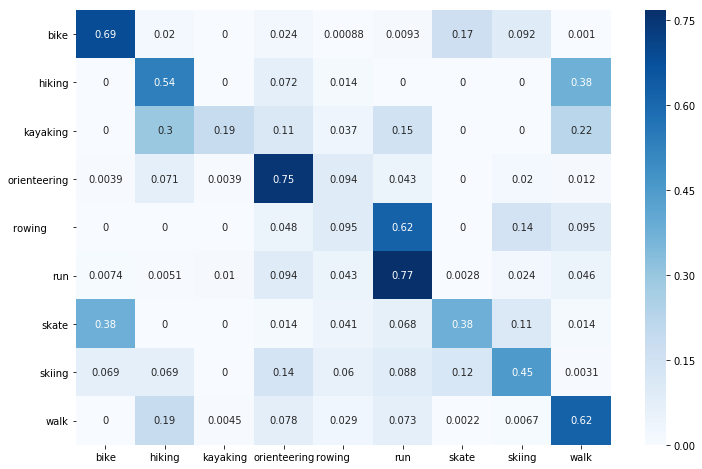

In [35]:
# confusion matrix
print('Logisitic Regression Model')
print('rows:actual columns:predicted')
print('')

y_pred = logreg.predict(X_test)
df_pred['lr'] = y_pred

# y_pred = logreg.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

f1 = f1_score(y_test, y_pred,average='micro')
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print('f1_score:',f1)
print('accuracy_score:',accuracy)
print('precision_score:',precision)
print('recall_score:',recall)

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

### KNN Model

In [36]:
# init model
knn = KNeighborsClassifier(n_neighbors=3)

# perform cross validation
score = cross_val_score(knn,X,y,cv=5)
print('score:',score.mean(),score)

# fit model
knn.fit(X_train, y_train)

# score model
print("train r2:",knn.score(X_train, y_train))
print("test r2:",knn.score(X_test, y_test))

score: 0.9570656424067601 [0.9595695  0.95701029 0.95593573 0.95981692 0.95299577]
train r2: 0.9880092592592593
test r2: 0.9053701443541938


KNN Model
rows:actual columns:predicted
f1_score: 0.9053701443541938
accuracy_score: 0.9053701443541938


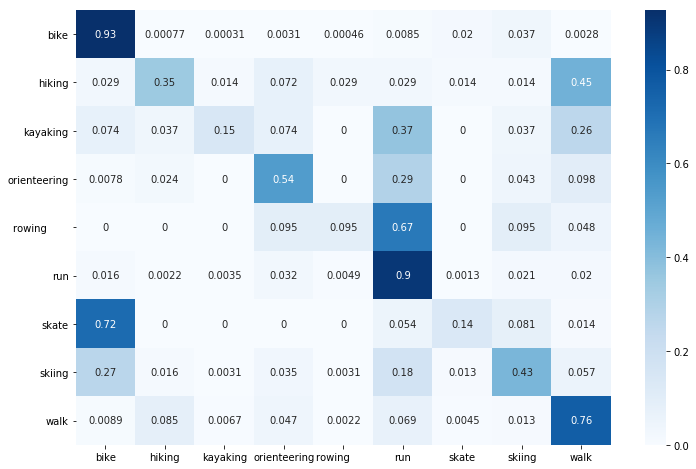

In [37]:
# confusion matrix
print('KNN Model')
print('rows:actual columns:predicted')

y_pred = knn.predict(X_test)
df_pred['knn'] = y_pred

# y_pred = knn.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

f1 = f1_score(y_test, y_pred,average='micro')
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print('f1_score:',f1)
print('accuracy_score:',accuracy)
print('precision_score:',precision)
print('recall_score:',recall)

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

### DTC Model

In [38]:
# init model
dtc = DecisionTreeClassifier(max_depth=10,random_state=3050)

# perform cross validation
score = cross_val_score(dtc,X,y,cv=5)
print(score.mean(),score)

# fit model
dtc = dtc.fit(X_train,y_train)

# score model
print("train r2:",dtc.score(X_train, y_train))
print("test r2:",dtc.score(X_test, y_test))

0.959268875824532 [0.96165257 0.95833596 0.95846091 0.96205808 0.95583686]
train r2: 0.839037037037037
test r2: 0.7996927738731535


DTC Model
rows:actual columns:predicted
f1_score: 0.7996927738731535
accuracy_score: 0.7996927738731535


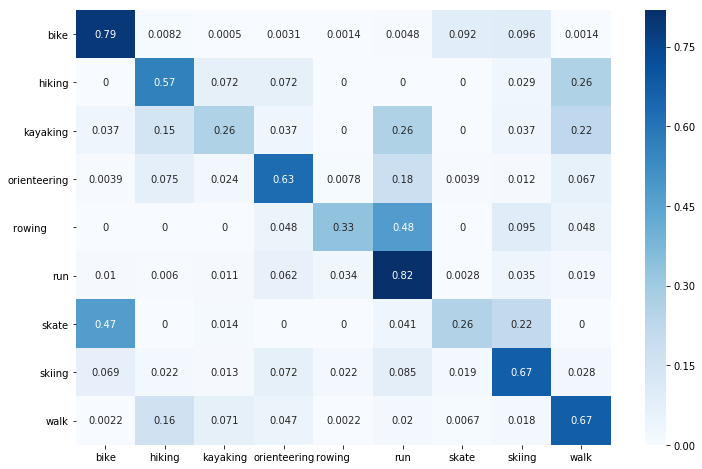

In [39]:
# confusion matrix
print('DTC Model')
print('rows:actual columns:predicted')

y_pred = dtc.predict(X_test)
df_pred['dtc'] = y_pred

# y_pred = dtc.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

f1 = f1_score(y_test, y_pred,average='micro')
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print('f1_score:',f1)
print('accuracy_score:',accuracy)
print('precision_score:',precision)
print('recall_score:',recall)

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

In [40]:
# # initialize the output file object
# dot_data = StringIO() 

# # my fit DecisionTreeRegressor object here is: dtr1
# # for feature_names i put the columns of my Xr matrix
# export_graphviz(dtc, 
#                 out_file=dot_data,  
#                 filled=True, 
#                 rounded=True,
#                 special_characters=True,
#                 feature_names=df_model[features].columns
#                )  

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

### RFC Model

In [41]:
# init model
rfc = RandomForestClassifier(n_estimators=10,max_depth=10,n_jobs=-1, random_state=3050)

# perform cross validation
score = cross_val_score(rfc,X,y,cv=5)
print(score.mean(),score)

# fit model
rfc = rfc.fit(X_train,y_train)

# score model
print("train r2:",rfc.score(X_train, y_train))
print("test r2:",rfc.score(X_test, y_test))



0.9629808932305639 [0.96487186 0.962818   0.96152268 0.965625   0.96006692]
train r2: 0.9116666666666666
test r2: 0.8520053869786625


RFC Model
rows:actual columns:predicted
f1_score: 0.8520053869786625
accuracy_score: 0.8520053869786625


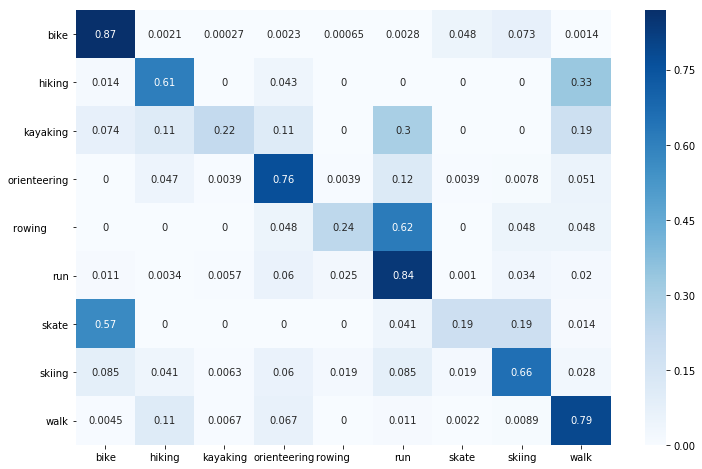

In [42]:
# confusion matrix
print('RFC Model')
print('rows:actual columns:predicted')

y_pred = rfc.predict(X_test)
df_pred['rfc'] = y_pred

# y_pred = rfc.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

f1 = f1_score(y_test, y_pred,average='micro')
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print('f1_score:',f1)
print('accuracy_score:',accuracy)
print('precision_score:',precision)
print('recall_score:',recall)

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

### SVC Model

In [43]:
# init model
svc = SVC()

# fit model
svc.fit(X_train, y_train)

# score model
print("train r2:",svc.score(X_train, y_train))
print("test r2:",svc.score(X_test, y_test))

train r2: 0.7092592592592593
test r2: 0.7513572661083288


SVC Model
rows:actual columns:predicted
f1_score: 0.7513572661083288
accuracy_score: 0.7513572661083288


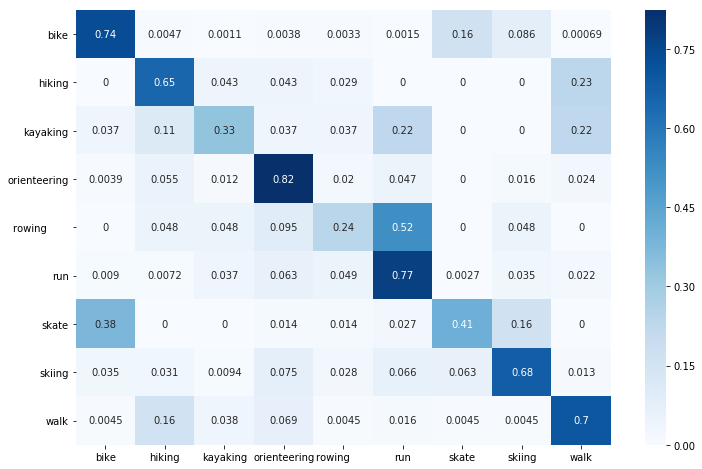

In [44]:
# confusion matrix
print('SVC Model')
print('rows:actual columns:predicted')

y_pred = svc.predict(X_test)
df_pred['svc'] = y_pred

# y_pred = logreg.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

f1 = f1_score(y_test, y_pred,average='micro')
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print('f1_score:',f1)
print('accuracy_score:',accuracy)
print('precision_score:',precision)
print('recall_score:',recall)

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

### Combine Model Predictions

In [45]:
# check predictions

# print(df_pred.shape)
# df_pred.head()

In [46]:
# cols = ['svc','rfc','dtc','lr','knn']
# df_pred = df_pred[cols]

# df_pred_mode = df_pred.mode(axis=1)
# df_pred_mode.reset_index(inplace=True)

# df_pred_final = df_pred_mode[0]

In [47]:
# for idx,row in df_pred_mode.iterrows():
    
#     if np.isnan(row[1]) == False:

#         mode_list = list(row[1:])
#         #print(mode_list)
        
#         pred_row = df_pred.iloc[idx,:]
#         #print(pred_row)
        
        
#         for idx_2,cell in pred_row.iteritems():
            
#             if cell in mode_list:
#                 #print(idx,idx_2,cell)
#                 df_pred_final[idx] = cell
#                 break

In [48]:
# # confusion matrix
# print('Combined Model')
# print('rows:actual columns:predicted')

# y_pred_final = df_pred_final.values

# f1 = f1_score(y_test, y_pred,average='micro')
# accuracy = accuracy_score(y_test,y_pred)
# print('f1_score:',f1)
# print('accuracy_score:',accuracy)

# # cohen_score = cohen_kappa_score(y_test, y_pred)
# # print('cohen_score',cohen_score)

# cm = confusion_matrix(y_test, y_pred_final)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

# plt.figure(figsize=(12,8))
# sns.heatmap(df_cm,annot=True,cmap="Blues");

### VotingClassifier Model

In [49]:
# init models

lr = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=3)
dtc = DecisionTreeClassifier(max_depth=10,random_state=3050)
rfc = RandomForestClassifier(n_estimators=10,max_depth=10,n_jobs=-1, random_state=3050)
svc = SVC()

In [50]:
# lr knn dtc rfc svc

estimators = [
        ('lr', lr), 
        ('knn', knn), 
        ('dtc', dtc),
        ('rfc', rfc),
        ('svc', svc)
            ]

vc = VotingClassifier(estimators=estimators, voting='hard')
#vc = VotingClassifier(estimators=estimators, voting='soft')
vc = vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)

VC Model
rows:actual columns:predicted
f1_score: 0.8499642270948192
accuracy_score: 0.8499642270948192


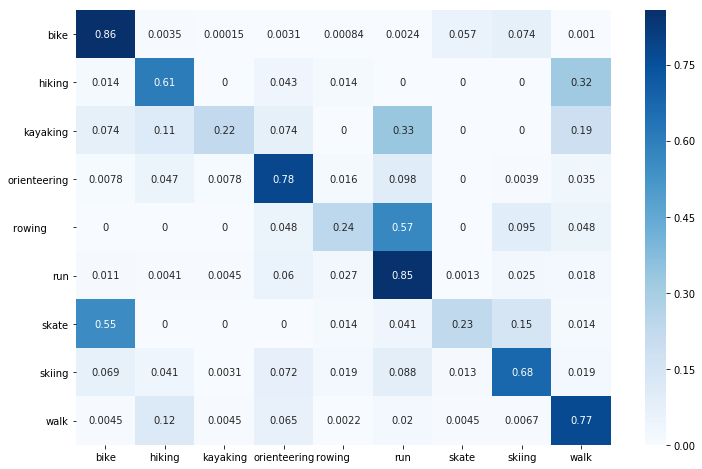

In [51]:
# confusion matrix
print('VC Model')
print('rows:actual columns:predicted')

f1 = f1_score(y_test, y_pred,average='micro')
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print('f1_score:',f1)
print('accuracy_score:',accuracy)
print('precision_score:',precision)
print('recall_score:',recall)

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

### GridSearch Model

In [52]:
# init models

estimators = {
    'lr': LogisticRegression(),
    'knn': KNeighborsClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'abc': AdaBoostClassifier(),
    'gbc': GradientBoostingClassifier()
}.items()

In [53]:
# init model parameters

params = {
    'lr': {
        'lr__penalty': ['l1','l2'],
        #'lr__penalty': ['l1','l2','elasticnet'],
        #'l1__ratio': np.arange(.1, 1, .2)
    },
    'knn': {
        'knn__n_neighbors': [3,5,7,9],
        'knn__weights': ['uniform','distance']
    },

    'dtc': {
        'dtc__max_features': ['auto', 'log2', None],
        'dtc__max_depth': np.arange(3, 16, 2),
        'dtc__min_samples_split': np.linspace(0.1, 0.5, 5)
    },
    'rfc': {
        'rfc__n_estimators': [10, 15, 20, 25],
        'rfc__max_features': ['auto', 'log2', None],
        'rfc__max_depth': np.arange(3, 16, 2),
        'rfc__min_samples_split': np.linspace(0.1, 0.5, 5)
    },
    'abc': {
        'abc__n_estimators' : np.arange(50, 151, 25),
        'abc__learning_rate' : np.linspace(0.1, 1, 8)
    }, 
    'gbc': {
        'gbc__n_estimators' : np.arange(10, 101, 30),
        'gbc__learning_rate' : np.linspace(0.1, 1, 4),
        'gbc__max_depth' : [1, 2, 3]
    }
}

In [54]:
models = []
parameters = []
best_score = []
roc_auc = []

for k,v in estimators:
    
    pipe = Pipeline([
            #('sc', StandardScaler()),
            (k,v)
                    ])
    
    gridsearch = GridSearchCV(
        estimator=pipe,
        param_grid=params[k],
        verbose=1,
        cv= 5,
        n_jobs=-1,
        return_train_score= True
    )

    gridsearch.fit(X_train, y_train)
    
    model = gridsearch.best_estimator_
    cv_score = gridsearch.cv_results_
    best_params = gridsearch.best_params_

    # predict y
    y_pred = model.predict(X_test)
    #y_pred = model.predict_proba(X_test)
    
    # print results
    print("Model: ", k)
    print("Best parameters:", best_params)
    print("Best score:", gridsearch.best_score_)
    display(pd.DataFrame(cv_score, columns = cv_score.keys()))    
    
    # append info to list
    models.append(k)
    best_score.append(gridsearch.best_score_)
    parameters.append(best_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.0min finished


Model:  lr
Best parameters: {'lr__penalty': 'l1'}
Best score: 0.5090648148148148


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      75.555516     21.006795         0.018552        0.016884   
1       4.215324      0.036782         0.009775        0.000398   

  param_lr__penalty                 params  split0_test_score  \
0                l1  {'lr__penalty': 'l1'}           0.505370   
1                l2  {'lr__penalty': 'l2'}           0.504769   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0           0.509583           0.511898           0.512500  ...   
1           0.509167           0.511111           0.513657  ...   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.509065        0.002943                1            0.508171   
1         0.508981        0.003222                2            0.507211   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.510347            0.508322            0.511042   
1            0.509977            0.507697            0.511806   

   split4_train_score  mean_train_score  std_train_score  
0            0.508183          0.509213         0.001231  
1            0.508287          0.508995         0.001687  

[2 rows x 21 columns]

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   49.3s finished


Model:  knn
Best parameters: {'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best score: 0.9778055555555556


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.212632      0.028057         1.300521        0.028552   
1       0.180319      0.010915         0.438626        0.012286   
2       0.163962      0.010863         1.314682        0.012383   
3       0.165358      0.008635         0.472337        0.011658   
4       0.161767      0.014180         1.344205        0.036857   
5       0.163363      0.009258         0.523200        0.027772   
6       0.161567      0.008438         1.426186        0.052103   
7       0.199066      0.017903         0.674596        0.058738   

  param_knn__n_neighbors param_knn__weights  \
0                      3            uniform   
1                      3           distance   
2                      5            uniform   
3                      5           distance   
4                      7            uniform   
5                      7           distance   
6                      9            uniform   
7                      9           distance   

                                              params  split0_test_score  \
0  {'knn__n_neighbors': 3, 'knn__weights': 'unifo...           0.977824   
1  {'knn__n_neighbors': 3, 'knn__weights': 'dista...           0.978333   
2  {'knn__n_neighbors': 5, 'knn__weights': 'unifo...           0.972454   
3  {'knn__n_neighbors': 5, 'knn__weights': 'dista...           0.973657   
4  {'knn__n_neighbors': 7, 'knn__weights': 'unifo...           0.967130   
5  {'knn__n_neighbors': 7, 'knn__weights': 'dista...           0.970000   
6  {'knn__n_neighbors': 9, 'knn__weights': 'unifo...           0.961065   
7  {'knn__n_neighbors': 9, 'knn__weights': 'dista...           0.964907   

   split1_test_score  split2_test_score  ...  mean_test_score  std_test_score  \
0           0.977546           0.978102  ...         0.977426        0.000618   
1           0.978009           0.978426  ...         0.977806        0.000640   
2           0.970972           0.972130  ...         0.971778        0.000612   
3           0.972315           0.973009  ...         0.973000        0.000533   
4           0.965463           0.965787  ...         0.966056        0.000763   
5           0.968426           0.968241  ...         0.968759        0.000753   
6           0.960509           0.961389  ...         0.961176        0.000628   
7           0.964907           0.964676  ...         0.964861        0.000363   

   rank_test_score  split0_train_score  split1_train_score  \
0                2            0.986748            0.986308   
1                1            0.999931            0.999884   
2                4            0.978229            0.978530   
3                3            0.999931            0.999884   
4                6            0.971840            0.972222   
5                5            0.999931            0.999884   
6                8            0.966377            0.966331   
7                7            0.999931            0.999884   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.986262            0.986354            0.985718   
1            0.999919            0.999907            0.999282   
2            0.978519            0.978785            0.978611   
3            0.999919            0.999907            0.999896   
4            0.972072            0.972454            0.972234   
5            0.999919            0.999907            0.999896   
6            0.966632            0.966713            0.966875   
7            0.999919            0.999907            0.999896   

   mean_train_score  std_train_score  
0          0.986278         0.000329  
1          0.999785         0.000252  
2          0.978535         0.000180  
3          0.999907         0.000016  
4          0.972164         0.000203  
5          0.999907         0.000016  
6          0.966586         0.000205  
7          0.999907         0.000016  

[8 rows x 22 columns]

Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 525 out of 525 | elapsed:   30.8s finished


Model:  dtc
Best parameters: {'dtc__max_depth': 7, 'dtc__max_features': None, 'dtc__min_samples_split': 0.1}
Best score: 0.5736666666666667


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.148205      0.013943         0.006183    9.764255e-04   
1         0.146607      0.023262         0.010971    4.232083e-03   
2         0.131448      0.005621         0.008378    5.299598e-03   
3         0.112100      0.014198         0.006383    1.016870e-03   
4         0.110305      0.014584         0.005186    7.453721e-04   
5         0.135637      0.023406         0.009376    6.295919e-03   
6         0.149401      0.007710         0.009773    6.129146e-03   
7         0.129253      0.011435         0.006981    8.921238e-04   
8         0.124866      0.016297         0.008178    4.942537e-03   
9         0.130052      0.015173         0.006782    2.631205e-03   
10        0.292018      0.009512         0.006583    1.738286e-03   
11        0.274865      0.014406         0.007979    5.499452e-03   
12        0.240756      0.017049         0.005584    7.977132e-04   
13        0.213429      0.018487         0.004987    1.061967e-06   
14        0.191488      0.021306         0.007180    3.909334e-03   
15        0.206049      0.010299         0.011569    6.070106e-03   
16        0.187698      0.022519         0.011369    1.027893e-02   
17        0.155386      0.013401         0.009772    8.110823e-03   
18        0.125863      0.016813         0.005386    4.886187e-04   
19        0.112100      0.012386         0.005784    7.473470e-04   
20        0.186501      0.029076         0.007579    2.238256e-03   
21        0.183509      0.012693         0.010571    7.480766e-03   
22        0.132047      0.016285         0.005585    4.888706e-04   
23        0.138828      0.021469         0.008975    5.045669e-03   
24        0.125464      0.010430         0.005186    3.989231e-04   
25        0.424065      0.010448         0.007580    2.239441e-03   
26        0.311366      0.008795         0.005786    3.989500e-04   
27        0.237964      0.008311         0.011370    1.037537e-02   
28        0.233775      0.027339         0.005186    3.990179e-04   
29        0.202459      0.011231         0.007779    4.608800e-03   
..             ...           ...              ...             ...   
75        0.217419      0.017390         0.010372    5.147468e-03   
76        0.167153      0.011398         0.009575    7.207819e-03   
77        0.137831      0.025219         0.007977    3.988505e-03   
78        0.122473      0.005140         0.005784    7.471049e-04   
79        0.126661      0.018997         0.005386    4.893581e-04   
80        0.217219      0.016729         0.010372    8.287072e-03   
81        0.173935      0.017407         0.009974    6.340102e-03   
82        0.139029      0.010104         0.005983    1.093016e-03   
83        0.120279      0.015224         0.014361    1.010313e-02   
84        0.119879      0.015938         0.007180    2.393683e-03   
85        0.413693      0.013386         0.009774    7.605968e-03   
86        0.276460      0.020178         0.005785    7.464423e-04   
87        0.249533      0.005022         0.008975    5.006811e-03   
88        0.213828      0.015663         0.004986    6.297718e-04   
89        0.184306      0.021936         0.011569    9.022555e-03   
90        0.189693      0.017878         0.007978    3.568107e-03   
91        0.158177      0.009744         0.007180    2.917771e-03   
92        0.133643      0.010072         0.007179    2.393580e-03   
93        0.105318      0.007426         0.005585    4.891831e-04   
94        0.111701      0.007109         0.005185    3.994231e-04   
95        0.190490      0.013602         0.009176    3.909283e-03   
96        0.159971      0.012370         0.005984    1.090752e-03   
97        0.126063      0.005970         0.005584    4.880912e-04   
98        0.131648      0.021034         0.004986    3.234067e-07   
99        0.121474      0.017622         0.009574    8.684896e-03   
100       0.408905      0.015768         0.012167    1.287206e-02   
101

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed: 15.5min finished


Model:  rfc
Best parameters: {'rfc__max_depth': 15, 'rfc__max_features': 'auto', 'rfc__min_samples_split': 0.1, 'rfc__n_estimators': 25}
Best score: 0.5755277777777777


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.784303      0.024369         0.055451        0.005338   
1         1.226719      0.018997         0.080385        0.010827   
2         1.505375      0.045388         0.095344        0.004789   
3         1.796993      0.042243         0.120678        0.004926   
4         0.654448      0.026853         0.047673        0.001324   
5         0.921135      0.021673         0.071409        0.004305   
6         1.209763      0.010554         0.090957        0.002130   
7         1.517141      0.032344         0.118482        0.005897   
8         0.541551      0.029398         0.049268        0.002326   
9         0.771136      0.013055         0.070211        0.004398   
10        0.981373      0.021713         0.089960        0.004479   
11        1.242478      0.026764         0.113098        0.004306   
12        0.488691      0.009711         0.049467        0.003867   
13        0.705312      0.031139         0.072008        0.007760   
14        0.900391      0.016953         0.092751        0.006148   
15        1.122595      0.029899         0.114693        0.004592   
16        0.399331      0.016885         0.048071        0.003420   
17        0.579448      0.012755         0.067220        0.001197   
18        0.765951      0.018281         0.092552        0.001935   
19        0.933103      0.033842         0.114693        0.004231   
20        0.710498      0.015159         0.049667        0.002705   
21        1.042411      0.031219         0.071011        0.003477   
22        1.419603      0.075721         0.098535        0.007604   
23        1.955569      0.049991         0.139427        0.009301   
24        0.707906      0.028120         0.057845        0.009462   
25        1.036228      0.024094         0.085371        0.006984   
26        1.365945      0.024597         0.110503        0.012074   
27        1.530903      0.075965         0.114692        0.005463   
28        0.504250      0.016587         0.047871        0.001544   
29        0.745803      0.034689         0.070211        0.002998   
..             ...           ...              ...             ...   
390       0.966213      0.024516         0.087169        0.001492   
391       1.213753      0.021204         0.111301        0.004020   
392       0.458572      0.017047         0.053657        0.011638   
393       0.682573      0.014337         0.067619        0.001165   
394       0.859700      0.039493         0.092153        0.003710   
395       1.124591      0.015014         0.117086        0.007993   
396       0.376192      0.006745         0.048269        0.002570   
397       0.554714      0.008771         0.068418        0.003489   
398       0.714289      0.012318         0.089362        0.004576   
399       0.886428      0.019250         0.111103        0.009021   
400       1.748921      0.014882         0.050066        0.005965   
401       2.625376      0.031655         0.071010        0.002475   
402       3.446978      0.046014         0.090758        0.000892   
403       4.329420      0.051841         0.115690        0.002821   
404       1.147129      0.017256         0.047673        0.003302   
405       1.671728      0.020492         0.066821        0.003399   
406       2.418130      0.057353         0.105318        0.017602   
407       3.173711      0.078493         0.130450        0.017393   
408       1.061360      0.020357         0.050663        0.007148   
409       1.554441      0.063261         0.073803        0.014561   
410       1.829305      0.022314         0.089760        0.004678   
411       2.292468      0.017004         0.106714        0.003889   
412       0.958235      0.012887         0.044680        0.001323   
413       1.387687      0.022449         0.064028        0.001465   
414       1.849053      0.020126         0.085771        0.001545   
415       2.318000      0.024196         0.104919        0.003477   
416

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 18.9min finished


Model:  abc
Best parameters: {'abc__learning_rate': 0.3571428571428572, 'abc__n_estimators': 50}
Best score: 0.46867592592592594


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        7.852357      0.268856         0.692745        0.024734   
1       11.510812      0.612510         1.031442        0.042006   
2       15.438307      0.570952         1.341213        0.035268   
3       18.834224      0.144758         1.721197        0.118470   
4       25.923063      1.306093         2.382428        0.199697   
5        8.766552      0.693465         0.735234        0.067828   
6       12.139331      0.484809         0.998131        0.015988   
7       14.856661      0.050795         1.334232        0.024877   
8       20.349172      1.926828         1.932633        0.241453   
9       25.802586      2.189822         2.154238        0.211484   
10       7.961901      0.384742         0.708904        0.061592   
11      11.231159      0.102965         0.979780        0.023548   
12      15.025810      0.097278         1.358566        0.047221   
13      19.540734      0.570692         1.670333        0.044679   
14      22.683527      0.514735         2.091607        0.116370   
15       7.905254      0.416593         0.686565        0.038444   
16      11.104697      0.052205         0.995137        0.025640   
17      15.019028      0.363485         1.366546        0.077901   
18      19.243928      0.590413         1.656171        0.025479   
19      22.933460      0.567440         2.053308        0.101800   
20       7.840829      0.452754         0.695340        0.038637   
21      11.217795      0.036313         1.000923        0.019160   
22      15.262776      0.566573         1.356373        0.084352   
23      18.992002      0.438375         1.650385        0.026622   
24      22.943232      0.562038         2.067072        0.162492   
25       7.557983      0.065744         0.665819        0.019611   
26      11.137410      0.049643         0.994742        0.021956   
27      15.370687      0.610221         1.415016        0.125745   
28      18.614810      0.103591         1.634030        0.022510   
29      23.302074      0.454676         2.091606        0.143175   
30       7.570351      0.071735         0.668413        0.010895   
31      11.201439      0.044062         1.006708        0.027622   
32      15.649341      0.397665         1.461093        0.123114   
33      18.649317      0.142932         1.628446        0.016479   
34      23.020029      0.600100         2.010821        0.035275   
35       7.512505      0.083829         0.662030        0.013636   
36      11.299377      0.315726         1.038621        0.082432   
37      15.837039      0.665791         1.361359        0.053904   
38      19.256892      0.949368         1.884960        0.333423   
39      27.116471      2.011044         2.281498        0.368340   

   param_abc__learning_rate param_abc__n_estimators  \
0                       0.1                      50   
1                       0.1                      75   
2                       0.1                     100   
3                       0.1                     125   
4                       0.1                     150   
5                  0.228571                      50   
6                  0.228571                      75   
7                  0.228571                     100   
8                  0.228571                     125   
9                  0.228571                     150   
10                 0.357143                      50   
11                 0.357143                      75   
12                 0.357143                     100   
13                 0.357143                     125   
14                 0.357143                     150   
15                 0.485714                      50   
16                 0.485714                      75   
17                 0.485714                     100   
18                 0.485714                     125   
19                 0.485714                     150   
20                 0.614286                      50   
21   

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 57.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 78.6min finished


Model:  gbc
Best parameters: {'gbc__learning_rate': 0.7, 'gbc__max_depth': 3, 'gbc__n_estimators': 100}
Best score: 0.9736018518518519


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        8.897203      0.397113         0.067818        0.009030   
1       33.888959      2.347686         0.167753        0.018297   
2       61.884680      3.052873         0.249534        0.026541   
3       82.694622      1.955509         0.332710        0.010432   
4       12.172442      0.349667         0.075998        0.006506   
5       49.212173      0.418976         0.185704        0.013446   
6       85.144469      0.766290         0.297203        0.014188   
7      124.981318      3.438684         0.420875        0.022400   
8       17.995867      0.521774         0.083977        0.007119   
9       75.317552      0.901326         0.261902        0.023172   
10     127.932224      1.497855         0.402924        0.035249   
11     181.256799      1.277006         0.550727        0.089928   
12      10.288282      0.459176         0.067221        0.008866   
13      38.383336      0.690051         0.162965        0.012921   
14      63.035599      2.099061         0.258111        0.020236   
15      92.192417      1.905929         0.335702        0.042950   
16      13.011597      0.605097         0.074003        0.010543   
17      53.225638      1.375934         0.198071        0.015941   
18      92.970735      1.359633         0.307380        0.014918   
19     131.305801      2.008695         0.416288        0.016077   
20      18.664079      0.346911         0.086571        0.011790   
21      73.541101      0.670355         0.229188        0.019558   
22     129.397704      1.113006         0.394945        0.025646   
23     182.863702      3.403637         0.524398        0.053478   
24       9.316679      0.074614         0.071212        0.009110   
25      36.535081      1.241434         0.155185        0.019569   
26      60.240079      1.297637         0.236968        0.013077   
27      86.663207      2.055329         0.316553        0.004662   
28      11.922111      0.093213         0.066225        0.001196   
29      49.739165      0.465690         0.178724        0.003860   
30      89.353610      0.561133         0.301794        0.022324   
31     129.281415      1.622871         0.428254        0.027274   
32      17.021672      0.581838         0.083179        0.009325   
33      68.407434      0.696608         0.204653        0.001934   
34     119.090473      0.728818         0.355650        0.025352   
35     169.083959      1.980192         0.461367        0.016981   
36       8.942481      0.541448         0.071609        0.013811   
37      36.184817      3.011792         0.147008        0.009284   
38      60.934419      6.106482         0.220412        0.012049   
39      91.853722     10.339989         0.324933        0.024701   
40      15.284318      1.257533         0.098139        0.019448   
41      71.168645     23.429648         0.235171        0.056973   
42     129.020912     49.664911         0.310570        0.098772   
43     189.285324     78.595689         0.379785        0.075020   
44      14.490442      0.431819         0.080586        0.004059   
45      73.694491     10.907856         0.246342        0.045883   
46     150.106516     39.542768         0.373204        0.057402   
47     215.689504     72.126191         0.453986        0.120216   

   param_gbc__learning_rate param_gbc__max_depth param_gbc__n_estimators  \
0                       0.1                    1                      10   
1                       0.1                    1                      40   
2                       0.1                    1                      70   
3                       0.1                    1                     100   
4                       0.1                    2                      10   
5                       0.1                    2                      40   
6                       0.1                    2                      70   
7                       0.1                    2               

In [55]:
# output gridsearch results

print(models)
print(best_score)
print(parameters)

['lr', 'knn', 'dtc', 'rfc', 'abc', 'gbc']
[0.5090648148148148, 0.9778055555555556, 0.5736666666666667, 0.5755277777777777, 0.46867592592592594, 0.9736018518518519]
[{'lr__penalty': 'l1'}, {'knn__n_neighbors': 3, 'knn__weights': 'distance'}, {'dtc__max_depth': 7, 'dtc__max_features': None, 'dtc__min_samples_split': 0.1}, {'rfc__max_depth': 15, 'rfc__max_features': 'auto', 'rfc__min_samples_split': 0.1, 'rfc__n_estimators': 25}, {'abc__learning_rate': 0.3571428571428572, 'abc__n_estimators': 50}, {'gbc__learning_rate': 0.7, 'gbc__max_depth': 3, 'gbc__n_estimators': 100}]
